In [11]:
import torch_geometric_temporal
print(torch_geometric_temporal.__version__)


0.54.0


In [12]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN
import matplotlib.pyplot as plt

# 1. Đọc và tiền xử lý dữ liệu
df = pd.read_csv('traffic.csv')
df = df[df['Junction'].isin([1,2,3])]  # Lọc junction 1-3
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')

# Pivot để mỗi hàng là một timestamp, cột là junction 1,2,3
df_pivot = df.pivot(index='DateTime', columns='Junction', values='Vehicles')

# Xử lý missing values: forward fill rồi backward fill, cuối cùng fill 0 nếu còn NaN
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)

# Chuyển sang numpy array
data = df_pivot.values  # shape (num_timestamps, 3)

# --- FIX: Split data BEFORE scaling ---
n_samples = data.shape[0]
train_size_idx = int(n_samples * 0.7)
val_size_idx = int(n_samples * 0.1)
test_size_idx = n_samples - train_size_idx - val_size_idx

train_data_unscaled = data[:train_size_idx]
val_data_unscaled = data[train_size_idx : train_size_idx + val_size_idx]
test_data_unscaled = data[train_size_idx + val_size_idx :]
# --- ADDED: Export train/val/test splits to CSV ---
# Use the DateTime index from df_pivot for the CSV files
df_train = df_pivot.iloc[:train_size_idx]
df_val = df_pivot.iloc[train_size_idx : train_size_idx + val_size_idx]
df_test = df_pivot.iloc[train_size_idx + val_size_idx :]

df_train.to_csv('GNN_train.csv')
df_val.to_csv('GNN_val.csv')
df_test.to_csv('GNN_test.csv')
print("Train, validation, and test data splits exported to GNN_train.csv, GNN_val.csv, and GNN_test.csv")
# Chuẩn hóa dữ liệu: Fit scaler ONLY on training data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)

# Transform validation and test data using the FITTED scaler
val_data_scaled = scaler.transform(val_data_unscaled)
test_data_scaled = scaler.transform(test_data_unscaled)

# Reshape cho phù hợp với PyG Temporal: [samples, nodes, features]
# X and y will be the scaled data for each respective set
X_train = train_data_scaled.reshape(-1, 3, 1)
y_train = train_data_scaled.reshape(-1, 3, 1) # Assuming auto-regressive setup

X_val = val_data_scaled.reshape(-1, 3, 1)
y_val = val_data_scaled.reshape(-1, 3, 1)

X_test = test_data_scaled.reshape(-1, 3, 1)
y_test = test_data_scaled.reshape(-1, 3, 1)

# 2. Xây dựng đồ thị dựa trên correlation matrix của TEST SET
train_corr = pd.DataFrame(train_data_unscaled, columns=[1, 2, 3]).corr().values
np.fill_diagonal(train_corr, 0)
adj_matrix = train_corr
print("Adjacency matrix based on training data correlation:\n", adj_matrix)
# 3. Tạo StaticGraphTemporalSignal
edge_index = np.array([[i, j] for i in range(3) for j in range(3) if i != j]).T
edge_weight = adj_matrix[edge_index[0], edge_index[1]]

def create_dataset(features_data, targets_data):
    features_list = [features_data[i].astype(np.float32) for i in range(features_data.shape[0])]
    targets_list = [targets_data[i].astype(np.float32) for i in range(targets_data.shape[0])]
    return StaticGraphTemporalSignal(
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        edge_weight=torch.tensor(edge_weight, dtype=torch.float),
        features=features_list,
        targets=targets_list
    )

train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)
test_dataset = create_dataset(X_test, y_test)

# 4. Định nghĩa mô hình DCRNN
class RecurrentGNN(torch.nn.Module):
    def __init__(self, node_features=1, filters=32):
        super().__init__()
        self.recurrent = DCRNN(node_features, filters, 1)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = RecurrentGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# 5. Huấn luyện mô hình
epochs = 1
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf')
best_model_state = None # To save the best model state

for epoch in range(epochs):
    model.train()
    total_loss = 0
    num_train_snapshots = 0  # Initialize counter for training snapshots
    for snapshot in train_dataset:
        optimizer.zero_grad()
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_true = snapshot.y.to(device)

        y_pred = model(x, edge_index, edge_weight)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_train_snapshots += 1 # Increment counter
    
    # Reset the iterator for the next epoch if it's a custom iterator that gets exhausted
    # For StaticGraphTemporalSignal, it resets its internal counter 't' when iteration starts.
    # If train_dataset were a standard list, this wouldn't be an issue.
    # For StaticGraphTemporalSignal, it should be fine as it re-iterates from the beginning.

    if num_train_snapshots > 0:
        avg_train_loss = total_loss / num_train_snapshots
    else:
        avg_train_loss = 0 # Avoid division by zero if dataset is empty

    # Validation
    model.eval()
    val_loss = 0
    num_val_snapshots = 0 # Initialize counter for validation snapshots
    with torch.no_grad():
        for snapshot in val_dataset:
            x = snapshot.x.to(device)
            edge_index = snapshot.edge_index.to(device)
            edge_weight = snapshot.edge_attr.to(device)
            y_true = snapshot.y.to(device)
            y_pred = model(x, edge_index, edge_weight)
            val_loss += criterion(y_pred, y_true).item()
            num_val_snapshots += 1 # Increment counter

    if num_val_snapshots > 0:
        avg_val_loss = val_loss / num_val_snapshots
    else:
        avg_val_loss = 0 # Avoid division by zero

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model state (optional, but good practice)
        best_model_state = model.state_dict()
        # print(f"Epoch {epoch+1}: New best validation loss: {best_val_loss:.6f}")
    else:
        patience_counter += 1
        # print(f"Epoch {epoch+1}: Validation loss did not improve. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state) # Load the best model state
        break


C:\Users\PLN\AppData\Local\Temp\ipykernel_21104\2861753952.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill').fillna(0)


Train, validation, and test data splits exported to GNN_train.csv, GNN_val.csv, and GNN_test.csv
Adjacency matrix based on training data correlation:
 [[0.         0.79425994 0.47142958]
 [0.79425994 0.         0.37592124]
 [0.47142958 0.37592124 0.        ]]
Using device: cuda
Epoch 1/1 - Train Loss: 0.000032 - Val Loss: 0.000055


Test Loss: 0.000205


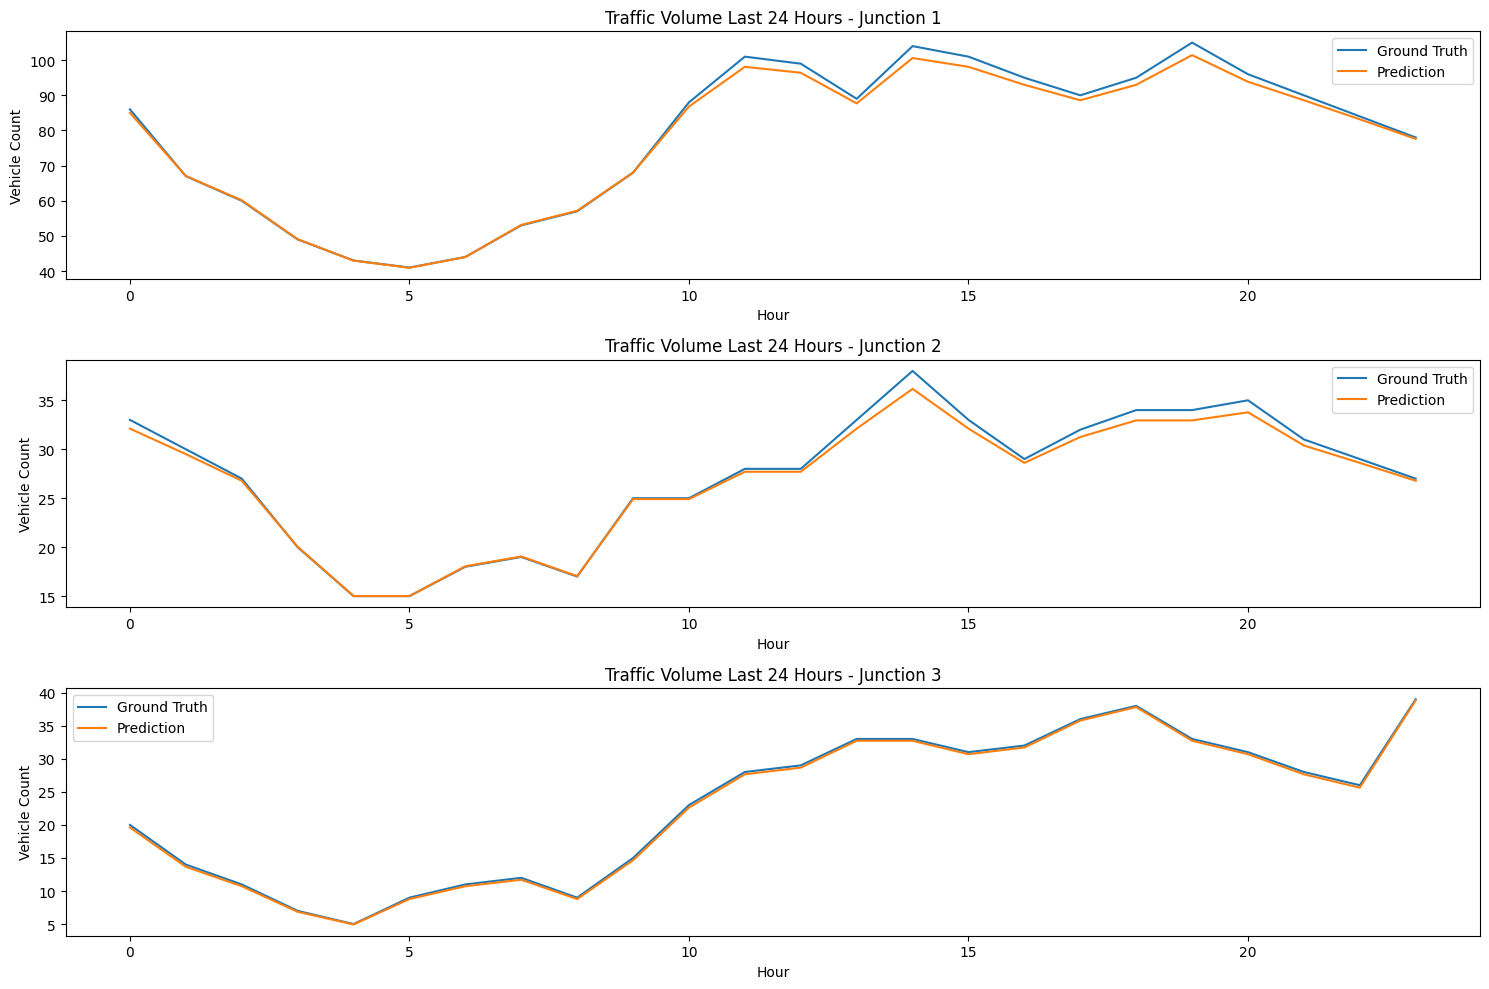

Model saved as traffic_gnn_dcrnn.pth


In [13]:

# 6. Đánh giá trên test set
model.eval()
test_loss = 0
num_test_snapshots = 0 # Initialize counter for test snapshots
with torch.no_grad():
    for snapshot in test_dataset:
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_true = snapshot.y.to(device)
        y_pred = model(x, edge_index, edge_weight)
        test_loss += criterion(y_pred, y_true).item()
        num_test_snapshots += 1 # Increment counter

if num_test_snapshots > 0:
    avg_test_loss = test_loss / num_test_snapshots
else:
    avg_test_loss = 0 # Avoid division by zero
print(f"Test Loss: {avg_test_loss:.6f}")

# 7. Vẽ biểu đồ dự đoán 24h cuối test set
preds = []
truths = []
with torch.no_grad():
    for snapshot in list(test_dataset)[-24:]:
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_true = snapshot.y.to(device)
        y_pred = model(x, edge_index, edge_weight)
        preds.append(y_pred.cpu().numpy().squeeze())
        truths.append(y_true.cpu().numpy().squeeze())

preds = np.array(preds)  # shape (24, 3)
truths = np.array(truths)

# Inverse scale về giá trị gốc
preds_inv = scaler.inverse_transform(preds)
truths_inv = scaler.inverse_transform(truths)

hours = np.arange(24)
junctions = ['Junction 1', 'Junction 2', 'Junction 3']

plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(hours, truths_inv[:, i], label='Ground Truth')
    plt.plot(hours, preds_inv[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 24 Hours - {junctions[i]}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.show()

# 8. Lưu mô hình
torch.save(model.state_dict(), 'traffic_gnn_dcrnn.pth')
print("Model saved as traffic_gnn_dcrnn.pth")

In [14]:
# RMSE, MAE and R2 of 3 junctions, for each junction
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
junctions_rmse = []
junctions_mae = []
junctions_r2 = []
for i in range(3):
    rmse = np.sqrt(mean_squared_error(truths_inv[:, i], preds_inv[:, i]))
    mae = mean_absolute_error(truths_inv[:, i], preds_inv[:, i])
    r2 = r2_score(truths_inv[:, i], preds_inv[:, i])
    junctions_rmse.append(rmse)
    junctions_mae.append(mae)
    junctions_r2.append(r2)
    print(f"Junction {i+1} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")


Junction 1 - RMSE: 1.70, MAE: 1.24, R2: 0.99
Junction 2 - RMSE: 0.68, MAE: 0.50, R2: 0.99
Junction 3 - RMSE: 0.29, MAE: 0.28, R2: 1.00


Junction 1 - RMSE: 2.64, MAE: 1.57, R2: 0.99
Junction 2 - RMSE: 1.00, MAE: 0.57, R2: 0.99
Junction 3 - RMSE: 0.31, MAE: 0.30, R2: 1.00


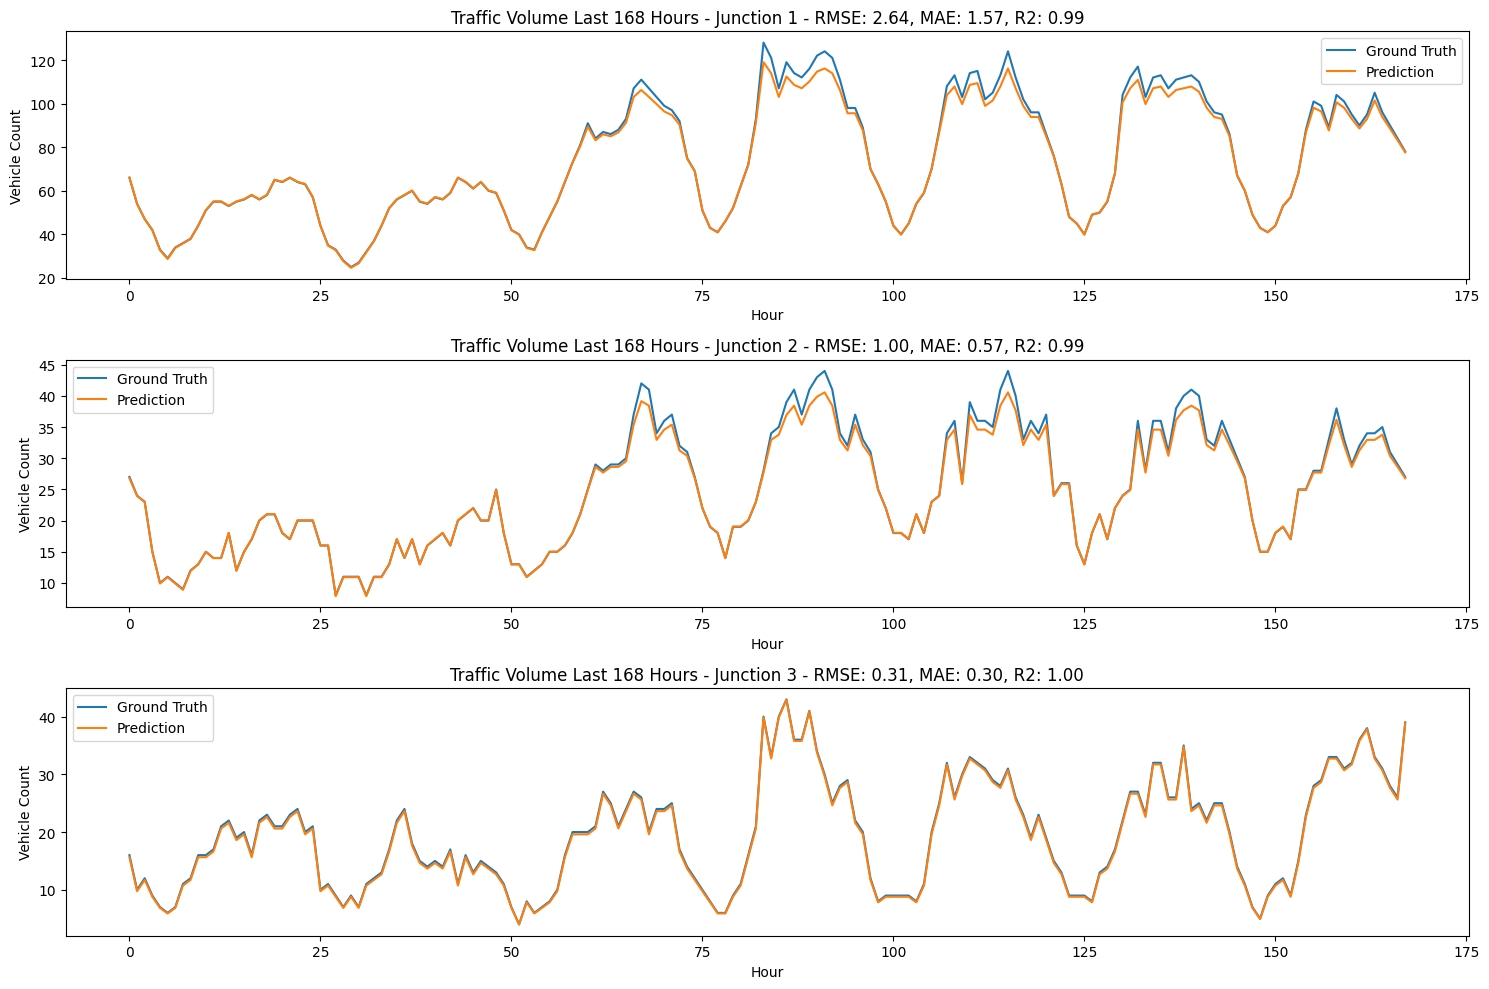

In [15]:
#plot 1 last week of test set
preds = []
truths = []
with torch.no_grad():
    for snapshot in list(test_dataset)[-168:]:
        x = snapshot.x.to(device)
        edge_index = snapshot.edge_index.to(device)
        edge_weight = snapshot.edge_attr.to(device)
        y_true = snapshot.y.to(device)
        y_pred = model(x, edge_index, edge_weight)
        preds.append(y_pred.cpu().numpy().squeeze())
        truths.append(y_true.cpu().numpy().squeeze())
preds = np.array(preds)  # shape (168, 3)
truths = np.array(truths)
# Inverse scale về giá trị gốc
preds_inv = scaler.inverse_transform(preds)
truths_inv = scaler.inverse_transform(truths)
hours = np.arange(168)
junctions = ['Junction 1', 'Junction 2', 'Junction 3']
#also put the RMSE, MAE and R2 of 3 junctions, for each junction in that week
junctions_rmse = []
junctions_mae = []
junctions_r2 = []
for i in range(3):
    rmse = np.sqrt(mean_squared_error(truths_inv[:, i], preds_inv[:, i]))
    mae = mean_absolute_error(truths_inv[:, i], preds_inv[:, i])
    r2 = r2_score(truths_inv[:, i], preds_inv[:, i])
    junctions_rmse.append(rmse)
    junctions_mae.append(mae)
    junctions_r2.append(r2)
    print(f"Junction {i+1} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
plt.figure(figsize=(15, 10))
for i in range(3):
    #put the RMSE, MAE and R2 in the title
    plt.subplot(3, 1, i+1)
    plt.plot(hours, truths_inv[:, i], label='Ground Truth')
    plt.plot(hours, preds_inv[:, i], label='Prediction')
    plt.title(f'Traffic Volume Last 168 Hours - {junctions[i]} - RMSE: {junctions_rmse[i]:.2f}, MAE: {junctions_mae[i]:.2f}, R2: {junctions_r2[i]:.2f}')
    plt.xlabel('Hour')
    plt.ylabel('Vehicle Count')
    plt.legend()
plt.tight_layout()
plt.show()